In [1]:
from dnafiber.postprocess import refine_segmentation
from dnafiber.deployment import run_one_file, ENSEMBLE, Models
from dnafiber.data.utils import convert_rgb_to_mask
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from dnafiber.utils import DEFAULT_CMAP
import logging
import pandas as pd
import seaborn as sns
from dnafiber.analysis.ratios import (
    create_swarm_plot,
    create_violin_plot,
    create_boxen_plot,
    create_boxen_swarmplot,
    load_experiment,
    select_N_closest_to_median,
    select_N_closest_to_mean,
    load_experiment_predictions,
    graders_statistical_test,
    compare_pairs
)
from tqdm.notebook import tqdm

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-09-02 14:45:12.420 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-02 14:45:13.127 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-02 14:45:13.128 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_input

In [2]:
root_imgs = Path("/home/clement/Documents/data/DNAFiber/Hugo/IHM-2021-26_Microscopy files_20210518/IHM-2021-26_Microscopy files_20210518/")
root_output = Path("/home/clement/Documents/data/DNAFiber/Hugo/IHM-2021-26_Microscopy files_20210518/output-tta/")
root_output.mkdir(exist_ok=True, parents=True)

pixel_size = 0.10774
all_files = sorted(list(root_imgs.rglob("*.dv")))

for file in tqdm(all_files):
    path_from_input = file.relative_to(root_imgs)
    output_file = root_output / path_from_input.with_suffix(".csv")
    if output_file.exists():
        continue  # Skip if the output file already exists
    
    predictions = run_one_file(
        file,
        model=ENSEMBLE,
        pixel_size=pixel_size,
        reverse_channels=False,
        use_tta=True,
        use_correction=True,
        prediction_threshold=1 / 3,
        verbose=False,
        bit_depth=14,
    )
    df = predictions.to_df(pixel_size=pixel_size, filter_invalid=False)
    df["image_name"] = path_from_input.stem
    output_file.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(output_file, index=False)

  0%|          | 0/53 [00:00<?, ?it/s]

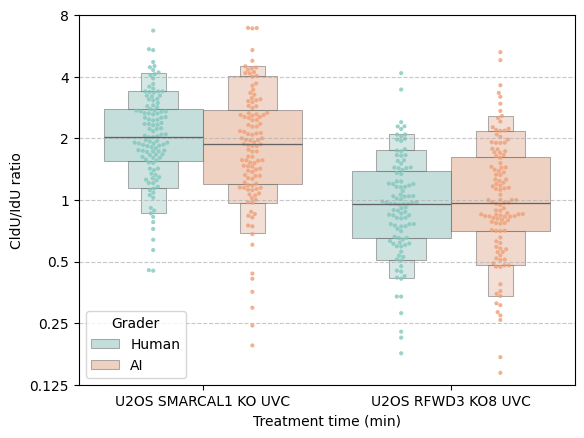

In [14]:


df_pred = load_experiment_predictions("/home/clement/Documents/data/DNAFiber/Hugo/IHM-2021-26_Microscopy files_20210518/output-tta/")
df_pred['Type'] = df_pred['image_name'].apply(lambda x: "_".join(x.split("_")[:-3]))

gt_root = "/home/clement/Documents/data/DNAFiber/Hugo/IHM-2021-26_Microscopy files_20210518/IHM-2021-26_counts.xlsx"
gt = pd.read_excel(gt_root, sheet_name=None, header=0)

gt_data = dict(Type=[], Grader=[], Ratio=[], Length=[])
for sheet_name, sheet_data in gt.items():
    valid_indices = sheet_data['Total'].notna() & sheet_data['Ratio G/R'].notna()
    total = sheet_data['Total'][valid_indices]
    ratio = sheet_data['Ratio G/R'][valid_indices]
    grader = ["Human"] * len(ratio)
    type_ = [sheet_name] * len(ratio)
    gt_data["Type"].extend(type_)
    gt_data["Grader"].extend(grader)
    gt_data["Ratio"].extend(ratio)
    gt_data["Length"].extend(total)

df_gt = pd.DataFrame(gt_data)
df_pred['Type'] = df_pred['Type'].map({
    "202105118_IHM-fibers_crispr-ctrl-NP": "U2OS Crispr Ctrl UVC",
    "20210518_IHM-fibers_U2OS_SMARCAL1-KO": "U2OS SMARCAL1 KO UVC",
    "20210518_IHM-fibers_U2OS_RFWD3-KO8": "U2OS RFWD3 KO8 UVC",
    "20210518_IHM-fibers_U2OS_RFWD3-KO4": "U2OS RFWD3 KO4 UVC",
})
df_gt['Type'] = df_gt['Type'].apply(lambda x: x.replace("_", " "))
df_pred = df_pred[df_pred.Valid]

palette = ["#81c8be", "#ef9f76"]

df = pd.concat([df_gt, df_pred], ignore_index=True)

df = df[df["Type"].isin([
    "U2OS RFWD3 KO8 UVC",
    "U2OS SMARCAL1 KO UVC",])]

# df = select_N_closest_to_median(df, N=None, column="Length")
create_boxen_swarmplot(df, palette=palette, dodge=True, rotate_xticks=0)
plt.ylim(0.125,8)

plt.ylabel("CldU/IdU ratio")
plt.xlabel("Treatment time (min)")
plt.savefig("u2os_202105118_boxen_swarmplot.png", dpi=300, bbox_inches='tight')